In [1]:
import math
import json

import cv2

import numpy as np
import numpy.ma as ma

import scipy as scipy

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from mpl_toolkits.axes_grid1 import make_axes_locatable

import itertools

import tensorflow as tf

import keras
from keras import backend as K
from keras.utils import np_utils
from keras.engine import Layer

from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling2D, Deconvolution2D, UpSampling2D, Reshape, Flatten, ZeroPadding2D, BatchNormalization, Lambda, Dropout, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.models import Model, Sequential
from keras.models import model_from_json

from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing import image

from keras.callbacks import Callback
from keras.models import load_model

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

#from vis.utils import utils
#from vis.visualization import visualize_saliency

from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib
from keras.utils import to_categorical

from scipy.ndimage import zoom

import os

from sklearn.model_selection import train_test_split

from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

import random

from sklearn.utils import class_weight

import theano
import theano.tensor as T

from keras.regularizers import l2

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

theano.config.opennp = True



Using TensorFlow backend.


In [2]:
#Parameters (Modify as needed)
img_size_x = 110
img_size_y = 110
img_size_z = 110

batch_size = 10
classes = 2
epochs = 50
lr = 27*1e-6

early_stopping_patience = 20
class_names = ['NC', 'AD']

In [3]:
def load_dataset_clean():
    AD_directory = "/home/ubuntu/project/Data/AD_clean/"
    NC_directory = "/home/ubuntu/project/Data/NC_clean/"
    
    AD_list = os.listdir(AD_directory)
    NC_list = os.listdir(NC_directory)
    

    All_directory = "/home/ubuntu/project/Data/AD_NC_Clean/"

    X = np.zeros((111,img_size_x,img_size_y,img_size_z,1))
    Y = np.zeros(111)
    
    l = os.listdir(All_directory)
    random.shuffle(l)
   
    
    objindex = 0
    for i, filename in enumerate(l):
        if (filename.startswith('.')):
            print ("hidden file")
        else:
            epi_img = nib.load(All_directory + filename)
            x = epi_img.get_fdata()
            x = (x-x.min())/x.max()
            
            x = np.expand_dims(x, axis=3)
            X[objindex] = x
            y = 0
            if filename in AD_list:
                y = 1
                
            Y[objindex] = y
            
            objindex += 1
            
    return X, Y



In [4]:
X, Y = load_dataset_clean()

In [5]:
train_data = X[0:70]
train_labels = Y[0:70]
val_data = X[70:111] 
val_labels = Y[70:111] 

#test_data = X[205:245]
#test_labels = Y[205:245]

In [6]:
print (train_data.shape)
print (train_labels.shape)

(70, 110, 110, 110, 1)
(70,)


In [7]:
print (val_labels)

[1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


In [8]:
#Builds keras 3D CNN model
def build_cnn(dimension = '3d', activation = 'softmax', heatmap = False, w_path = None, compile_model = True):
    input_3d = (img_size_x, img_size_y, img_size_z, 1)
    
    #VoxCNN architecture
    
    model = Sequential()
    # 1st Volumetric Convolutional block
    model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same', input_shape=input_3d))
    model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 2nd Volumetric Convolutional block
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 3rd Volumetric Convolutional block
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # 4th Volumetric Convolutional block
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    # 1th Deconvolutional layer with batchnorm and dropout for regularization
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # 2th Deconvolutional layer
    model.add(Dense(64, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    # Output with softmax nonlinearity for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if w_path:
        model.load_weights(w_path)
    
    opt = keras.optimizers.Adam(lr)
    
    if(compile_model):
        model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    
    print ('Done building model.')

    return model

In [9]:
model = build_cnn(dimension = '3d', compile_model = True)

W1205 23:42:25.706437 139938613438208 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1205 23:42:25.726871 139938613438208 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1205 23:42:25.729829 139938613438208 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1205 23:42:25.963421 139938613438208 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The n

Done building model.


In [10]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 110, 110, 110, 8)  224       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 110, 110, 110, 8)  1736      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 55, 55, 55, 8)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 55, 55, 55, 16)    3472      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 55, 55, 55, 16)    6928      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 27, 27, 27, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 27, 27, 27, 32)    13856     
__________

In [11]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

roc_val_scores = []

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        roc_val_scores.append(round(roc_val,4))
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [12]:
# Fitting model architecture to data, also runs loss/accuracy tracker
def fit_model(model, v, train_data, train_labels, val_data, val_labels):
    roc_val_scores = []
    model_weights_file = 'img_classifier_weights_%s.h5' %v
    epoch_weights_file = 'img_classifier_weights_%s_{epoch:02d}_{val_acc:.2f}.hdf5' %v
    model_file = 'img_classifier_model_%s.h5' %v
    history_file = 'img_classifier_history_%s.json' %v
    
    def save_model_and_weights():
        model.save(model_file)
        model.save_weights(model_weights_file)
        
        return 'Saved model and weights to disk!'

    def save_model_history(m):
        with open(history_file, 'w', encoding="utf8") as history_json_file:
            json.dump(m.history, history_json_file)
        
        return 'Saved model history to disk!'
    
    def visualise_accuracy(m):
        plt.plot(m.history['acc'])
        plt.plot(m.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
      
    def visualise_loss(m):
        plt.plot(m.history['loss'])
        plt.plot(m.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.ylim(0,1.5)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    
    def model_callbacks():
        checkpoint = ModelCheckpoint(epoch_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')
        
        roc = roc_callback(training_data=(train_data, train_labels),validation_data=(val_data,val_labels))
        
        return [checkpoint, roc]
        
    callbacks_list = model_callbacks()
    
    y_ints = [y.argmax() for y in train_labels]
    
    #class_weights = class_weight.compute_class_weight('balanced',
                                                 #np.unique(y_ints),
                                                 #y_ints)
    #print (class_weights)
    
    m = model.fit(train_data,train_labels,batch_size=batch_size, epochs=epochs, verbose=1,shuffle=True,validation_data=(val_data,val_labels),callbacks=callbacks_list)
    
    print (save_model_and_weights())
    print (save_model_history(m))
    
    visualise_accuracy(m)
    visualise_loss(m)
    
    return m

In [13]:
print(train_data.shape)
print(train_labels.shape)

(70, 110, 110, 110, 1)
(70,)


In [15]:
m = fit_model(model, "v1", train_data, train_labels, val_data, val_labels)

Train on 70 samples, validate on 41 samples
Epoch 1/50


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[10,110,110,110,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv3d_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics/acc/Mean_1/_301]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[10,110,110,110,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv3d_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [33]:
def evaluate_model(m, weights, test_data, test_labels):    
     
    plt.close('all')

    m.load_weights(weights)
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print ("Done compiling model.")
    
    prediction = m.predict(test_data)
    #prediction_labels = np_utils.to_categorical(np.argmax(prediction, axis=1), nb_classes)
    
    #print (prediction)
    
    pred = []
    for p in prediction:
        if float(p[0]) > 0.5:
            pred.append(1)
        else:
            pred.append(0)
    print (pred)
    
    print ('Accuracy on test data:', accuracy_score(test_labels, pred))

    print ('Classification Report')
    print (classification_report(test_labels, pred, target_names = ['NC', 'AD']))
    
    cm = confusion_matrix(test_labels,  pred)

    print(cm)


    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()

Done compiling model.
[1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Accuracy on test data: 0.7560975609756098
Classification Report
              precision    recall  f1-score   support

          NC       0.84      0.70      0.76        23
          AD       0.68      0.83      0.75        18

    accuracy                           0.76        41
   macro avg       0.76      0.76      0.76        41
weighted avg       0.77      0.76      0.76        41

[[16  7]
 [ 3 15]]


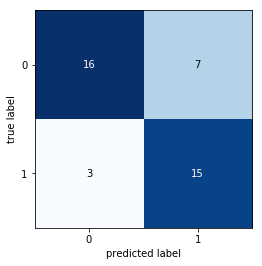

In [34]:
evaluate_model(model, 'img_classifier_weights_v1.h5', val_data, val_labels)

In [37]:
print (roc_val_scores[50:100])

[0.5459, 0.5483, 0.5507, 0.5507, 0.5676, 0.5966, 0.6184, 0.5918, 0.57, 0.5604, 0.5556, 0.5628, 0.5652, 0.5652, 0.5604, 0.5676, 0.5749, 0.5749, 0.5725, 0.5749, 0.5821, 0.587, 0.587, 0.5918, 0.6039, 0.6329, 0.6353, 0.6304, 0.6594, 0.6546, 0.6546, 0.6884, 0.686, 0.657, 0.686, 0.7101, 0.6932, 0.7295, 0.7367, 0.7415, 0.7681, 0.7874, 0.7826, 0.7729, 0.7585, 0.7778, 0.7681, 0.7585, 0.8019, 0.7899]


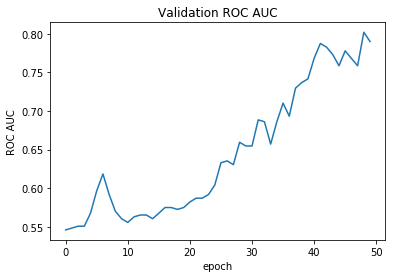

In [38]:
plt.plot(roc_val_scores[50:100])
plt.title('Validation ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('epoch')
plt.show()